In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
def radian(d):
    return d * np.pi/180

df = pd.read_excel('test_data.xlsx')
df = df.drop(0)
df = df.drop(columns=['No', 'rpm'])
df.columns = ['Angle'] + list(df.columns[1:])
for i in range(1, len(df)+1):
    if type(df.loc[i, 'Angle']) == str:
        temp = int(df.loc[i, 'Angle'][:-1])
        temp = radian(temp)
    df.loc[i, 'Angle'] = temp
df.head(70)

,Angle,Flowrate,Total Head,delP,Power,Efficiency
1,0.0,1,9.367082,91.6154,16.486568,9.26162
2,0.0,2,8.20719,80.271,14.058919,19.032046
3,0.0,3,7.78425,76.1344,12.829112,29.672514
4,0.0,4,8.380769,81.9687,12.778301,42.764526
5,0.0,5,8.838554,86.4461,12.993447,55.442114
...,...,...,...,...,...,...
66,0.785398,4,5.527255,54.0597,9.573941,37.643641
67,0.785398,5,4.634536,45.3284,8.002546,47.202063
68,0.785398,5.5,3.376265,33.0218,6.712262,45.096545
69,0.785398,6,2.363717,23.1185,5.677934,40.716392


# 데이터 찍어보기

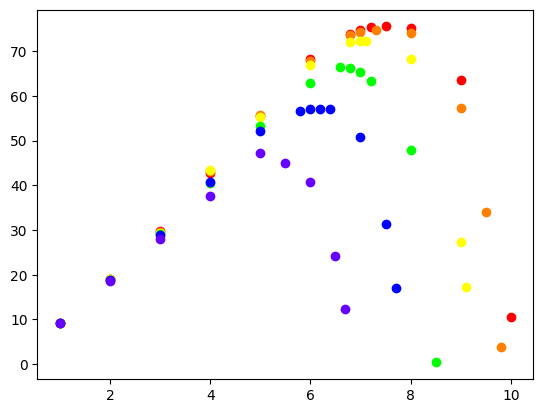

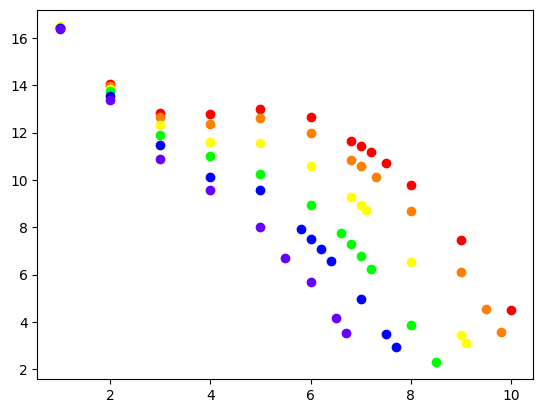

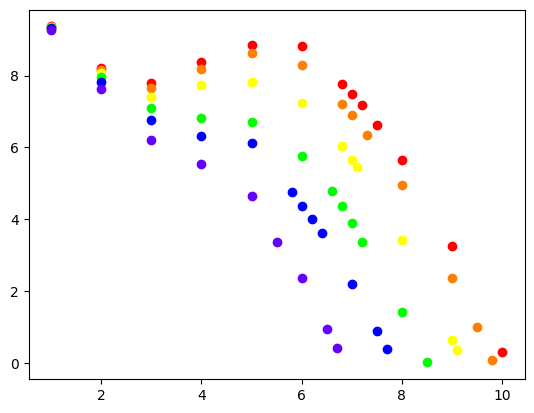

In [5]:
color_list = (
    (1, 0, 0),
    (1, 0.5, 0),
    (1, 1, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.4, 0, 1)
)

from collections import defaultdict
data = defaultdict(list)

for row in df.iloc:
    data[row['Angle']].append(row['Flowrate':])

for i,(a, data_list) in enumerate(data.items()):
    x = [row['Flowrate'] for row in data_list]
    y = [row['Efficiency'] for row in data_list]
    plt.scatter(x, y, color=color_list[i])

plt.show()

for i,(a, data_list) in enumerate(data.items()):
    x = [row['Flowrate'] for row in data_list]
    y = [row['Power'] for row in data_list]
    plt.scatter(x, y, color=color_list[i])

plt.show()

for i,(a, data_list) in enumerate(data.items()):
    x = [row['Flowrate'] for row in data_list]
    y = [row['Total Head'] for row in data_list]
    plt.scatter(x, y, color=color_list[i])

plt.show()

# 다항 회귀
## 독립변수
    - Flowrate
    - Angle

### Efficiency 예측

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

X = np.array(
        list(zip(df['Angle'], df['Flowrate'])),
        dtype=np.float64
)

Y = np.array(
        df['Efficiency'],
        dtype=np.float64
)

poly_features = PolynomialFeatures(9)
X_poly = poly_features.fit_transform(X)
lin_reg = LinearRegression()
model = lin_reg.fit(X_poly, Y)

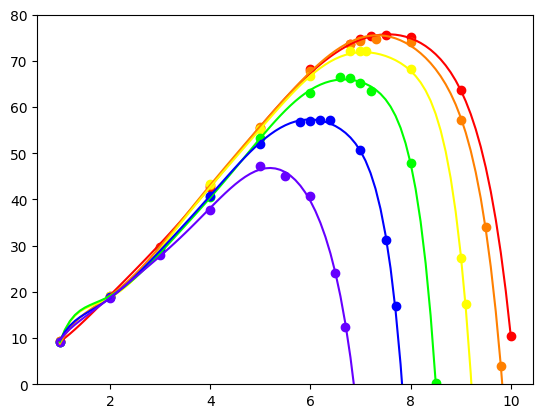

In [7]:
for i, a in enumerate((0,5,15,25,35,45)):
    a = radian(a)
    inp_angle = np.array([a for _ in range(10,101,1)]).reshape(-1,1)
    inp_flow = np.arange(1,10.1,0.1).reshape(-1,1)
    inp_data = np.concatenate((inp_angle, inp_flow), axis=1)
    
    prediction = model.predict(poly_features.transform(inp_data))
    plt.plot(inp_flow, prediction, color=color_list[i])
    
for i,(a, data_list) in enumerate(data.items()):
    x = [row['Flowrate'] for row in data_list]
    y = [row['Efficiency'] for row in data_list]
    plt.scatter(x, y, color=color_list[i])
    
plt.ylim((0,80))
plt.show()

### delP 예측

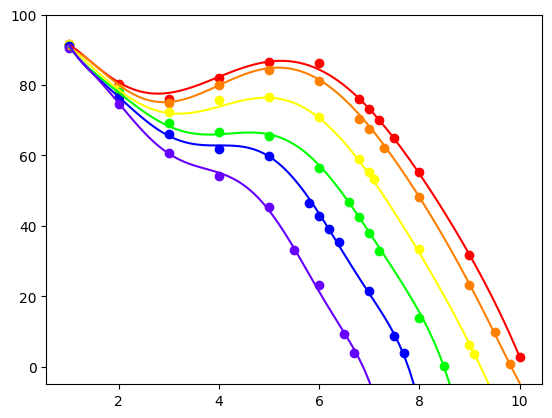

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = np.array(
        list(zip(df['Angle'], df['Flowrate'])),
        dtype=np.float64
)

Y = np.array(
        df['delP'],
        dtype=np.float64
)

poly_features = PolynomialFeatures(9)
X_poly = poly_features.fit_transform(X)
lin_reg = LinearRegression()
model = lin_reg.fit(X_poly, Y)

for i, a in enumerate((0,5,15,25,35,45)):
    a = radian(a)
    inp_angle = np.array([a for _ in range(10,101,1)]).reshape(-1,1)
    inp_flow = np.arange(1,10.1,0.1).reshape(-1,1)
    inp_data = np.concatenate((inp_angle, inp_flow), axis=1)
    
    prediction = model.predict(poly_features.transform(inp_data))
    plt.plot(inp_flow, prediction, color=color_list[i])
    
for i,(a, data_list) in enumerate(data.items()):
    x = [row['Flowrate'] for row in data_list]
    y = [row['delP'] for row in data_list]
    plt.scatter(x, y, color=color_list[i])
    
plt.ylim((-5,100))
plt.show()

# two-step 모델링
    1. Flowrate를 이용해 다항회귀를 통해 곡선
    2. Angle로 계수를 만들어 1.과 곱 수행

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class model_1(nn.Module):
    def __init__(self, x_dim):
        super(model_1, self).__init__()
        self.x_dim = x_dim
        self.lin_1 = nn.Linear(1,1)
        self.lin_2 = nn.Linear(x_dim, 1)
    
    def forward(self, x, angle):
        a_c = self.lin_1(torch.cos(angle))
        x /= a_c
        polynomial_list = []
        for i in range(1, self.x_dim+1):
            polynomial_list.append(x ** i)
        else:
            x = torch.cat(polynomial_list, 1)
        y = self.lin_2(x)
        return y * a_c, a_c

In [10]:
class model_2(nn.Module):
    def __init__(self, x_dim):
        super(model_2, self).__init__()
        self.x_dim = x_dim
        self.lin_1 = nn.Linear(1,1)
        self.lin_2 = nn.Linear(1,1)
        self.lin_3 = nn.Linear(x_dim, 1)
    
    def forward(self, x, angle):
        a_c_1 = self.lin_1(torch.cos(angle))
        a_c_2 = self.lin_2(torch.cos(angle))
        x /= a_c_1
        polynomial_list = []
        for i in range(1, self.x_dim+1):
            polynomial_list.append(x**i)
        else:
            x = torch.cat(polynomial_list, 1)
        y = self.lin_3(x)
        return y * a_c_2, (a_c_1, a_c_2)

In [38]:
def train(y, 
          lr, 
          model_cls,
          x_dim = 9,
          epoch=300000):
    flow = np.array(
            df['Flowrate'],
            dtype=np.float32
    ).reshape(-1,1)

    angle = np.array(
            df['Angle'],
            dtype=np.float32
    ).reshape(-1,1)

    target = np.array(
            df[y],
            dtype=np.float32
    ).reshape(-1,1)

    torch.manual_seed(42)
    model = model_cls(x_dim)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for i in range(epoch):
        a_t = torch.tensor(angle)
        t_t = torch.tensor(target)
        f_t = torch.tensor(flow)
        optimizer.zero_grad()
        y, _ = model(f_t, a_t)
        loss = F.mse_loss(y, t_t)
        loss.backward()
        optimizer.step()
        if i % 10000 == 0:
            print(f'\rloss: {loss.data:.3}     ', end='')
    else:
        print('done')
    
    return model

In [11]:
x_dim = 9

flow = np.array(
        df['Flowrate'],
        dtype=np.float32
).reshape(-1,1)

angle = np.array(
        df['Angle'],
        dtype=np.float32
).reshape(-1,1)

target = np.array(
        df['Efficiency'],
        dtype=np.float32
).reshape(-1,1)

torch.manual_seed(42)
model = model_1(x_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# lr 1e-2
model.train()

for i in range(300000):
    a_t = torch.tensor(angle)
    t_t = torch.tensor(target)
    f_t = torch.tensor(flow)
    optimizer.zero_grad()
    y, _ = model(f_t, a_t)
    loss = F.mse_loss(y, t_t)
    loss.backward()
    optimizer.step()
    if i % 10000 == 0:
        print(f'loss: {loss.data:.3}')
else:
    print('done')

loss: 1.71e+12
loss: 1.76e+05
loss: 2.77e+03
loss: 2.33e+02
loss: 1.01e+02
loss: 23.9
loss: 23.9
loss: 23.8
loss: 23.7
loss: 23.6
loss: 23.6
loss: 23.5
loss: 23.5
loss: 23.5
loss: 24.3
loss: 23.4
loss: 23.5
loss: 23.5
loss: 23.4
loss: 23.4
loss: 23.6
loss: 23.4
loss: 23.4
loss: 23.4
loss: 23.4
loss: 23.4
loss: 23.4
loss: 23.4
loss: 23.3
loss: 23.3
done


In [12]:
model_1_x = []
model_1_y = []
model_1_c = []

for i,(a, data_list) in enumerate(data.items()):
    a = np.cos(a).reshape(-1)
    w1 = model.lin_1.weight.clone().detach().numpy().squeeze()
    b1 = model.lin_1.bias.clone().detach().numpy().squeeze()
    b1 /= w1
    w1 /= w1
    
    a_c = w1*a + b1
    x = [row['Flowrate']/a_c for row in data_list]
    y = [row['Efficiency']/a_c for row in data_list]
    c = [color_list[i] for _ in data_list]
    model_1_x += x
    model_1_y += y
    model_1_c += c

In [13]:
w1, b1

(array(1., dtype=float32), array(-0.07599878, dtype=float32))

In [35]:
x_dim = 9

flow = np.array(
        df['Flowrate'],
        dtype=np.float32
).reshape(-1,1)

angle = np.array(
        df['Angle'],
        dtype=np.float32
).reshape(-1,1)

target = np.array(
        df['Efficiency'],
        dtype=np.float32
).reshape(-1,1)

torch.manual_seed(42)
model = model_2(x_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# lr 1e-3
model.train()

for i in range(300000):
    a_t = torch.tensor(angle)
    t_t = torch.tensor(target)
    f_t = torch.tensor(flow)
    optimizer.zero_grad()
    y, _ = model(f_t, a_t)
    loss = F.mse_loss(y, t_t)
    loss.backward()
    optimizer.step()
    if i % 10000 == 0:
        print(f'loss: {loss.data:.3}')
else:
    print('done')

loss: 3.41e+11


KeyboardInterrupt: 

In [15]:
model_2_x = []
model_2_y = []
model_2_c = []

for i,(a, data_list) in enumerate(data.items()):
    a = np.cos(a)
    # Q축 보정
    w1 = model.lin_1.weight.clone().detach().numpy().squeeze()
    b1 = model.lin_1.bias.clone().detach().numpy().squeeze()
    b1 /= w1
    w1 /= w1
    # Efficiency축 보정
    w2 = model.lin_2.weight.clone().detach().numpy().squeeze()
    b2 = model.lin_2.bias.clone().detach().numpy().squeeze()
    b2 /= w2
    w2 /= w2
    
    a_c_1 = w1*a + b1
    a_c_2 = w2*a + b2
    x = [row['Flowrate']/a_c_1 for row in data_list]
    y = [row['Efficiency']/a_c_2 for row in data_list]
    c = [color_list[i] for _ in data_list]
    
    model_2_x += x
    model_2_y += y
    model_2_c += c

In [26]:
print('x축 a,b')
print(w1, f'{b1:.3f}')
print('y축 a,b')
print(w2, f'{b2:.3f}')

x축 a,b
1.0 -0.056
y축 a,b
1.0 -0.248


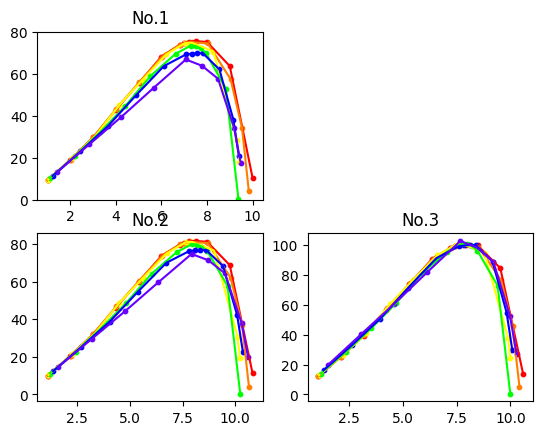

In [17]:
plt.subplot(2,2,1)
plt.title('No.1')

for i,(a, data_list) in enumerate(data.items()):
    x = [row['Flowrate']/np.cos(a) for row in data_list]
    y = [row['Efficiency']/np.cos(a) for row in data_list]
    plt.scatter(x, y, s=10, color=color_list[i])
    plt.plot(x, y, color=color_list[i])

plt.ylim((0,80))

plt.subplot(2,2,3)
plt.title('No.2')

temp_dict = defaultdict(lambda:[[],[]])
for i in range(len(model_1_x)):
    x, y, c = model_1_x[i], model_1_y[i], model_1_c[i]
    plt.scatter(x,y, s=10, color=c)
    temp_dict[c][0].append(x)
    temp_dict[c][1].append(y)
    
for c, v in temp_dict.items():
    plt.plot(v[0], v[1], color=c)

plt.subplot(2,2,4)
plt.title('No.3')

temp_dict = defaultdict(lambda:[[],[]])
for i in range(len(model_1_x)):
    x, y, c = model_2_x[i], model_2_y[i], model_2_c[i]
    plt.scatter(x,y, s=10, color=c)
    temp_dict[c][0].append(x)
    temp_dict[c][1].append(y)
    
for c, v in temp_dict.items():
    plt.plot(v[0], v[1], color=c)


plt.show()

### No.1
- Q축과 y축에 cos(angle)를 각각 나누어줌
### No.2
- Q축과 y축에 (a * cos(angle) + b)를 각각 나누어줌
### No.3
- Q축에 (a_1 * cos(angle) + b_1)를 나누고,
  y축에 (a_2 * cos(angle) + b_2)를 나눔

In [47]:
delP_model_1 = train('delP', 1e-3, model_1, epoch=300000)

loss: 43.2         done


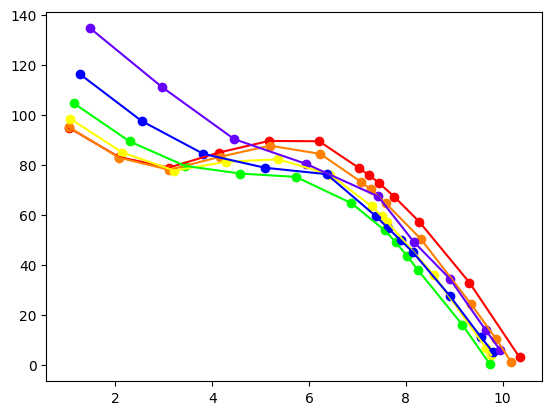

In [41]:
for i,(a, data_list) in enumerate(data.items()):
    a = np.cos(a).reshape(-1)
    w1 = model.lin_1.weight.clone().detach().numpy().squeeze()
    b1 = model.lin_1.bias.clone().detach().numpy().squeeze()
    b1 /= w1
    w1 /= w1
    
    a_c = w1*a + b1
    x = [row['Flowrate']/a_c for row in data_list]
    y = [row['delP']/a_c for row in data_list]
    plt.plot(x, y, color=color_list[i])
    plt.scatter(x, y, color=color_list[i])

plt.show()

In [42]:
delP_model_2 = train('delP', 1e-3, model_2, epoch=300000)

loss: 35.9         done


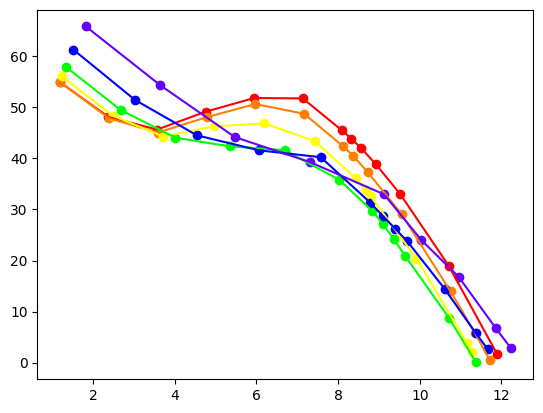

In [44]:
for i,(a, data_list) in enumerate(data.items()):
    a = np.cos(a)
    # Q축 보정
    w1 = model.lin_1.weight.clone().detach().numpy().squeeze()
    b1 = model.lin_1.bias.clone().detach().numpy().squeeze()
    b1 /= w1
    w1 /= w1
    # Efficiency축 보정
    w2 = model.lin_2.weight.clone().detach().numpy().squeeze()
    b2 = model.lin_2.bias.clone().detach().numpy().squeeze()
    b2 /= w2
    w2 /= w2
    
    a_c_1 = w1*a + b1
    a_c_2 = w2*a + b2
    x = [row['Flowrate']/a_c_1 for row in data_list]
    y = [row['delP']/a_c_2 for row in data_list]
    
    plt.plot(x, y, color=color_list[i])
    plt.scatter(x, y, color=color_list[i])

plt.show()